In [35]:
# %% [markdown]
# # Step 6 — Minimal but Clean Backtesting (LSTM/Transformer)
#
# This notebook:
# 1) Builds dataset splits with your DataConfig (same as training)
# 2) Loads (or recomputes) test probabilities p_up_test from the trained checkpoint
# 3) Loads (or derives) the validation-optimal threshold theta_opt
# 4) Runs a simple long/flat backtest with +1 bar execution and costs
# 5) Saves KPIs and plots equity vs Buy&Hold + drawdown
#
# Notes:
# - No use of `__file__` (notebook-safe path handling).
# - Robust checkpoint loading: reconstruct model from config, extract `state_dict`, fix `module.` prefix.
# - Uses simple returns; converts from log returns if needed.

# %%
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch

# -------- Project root detection (works in notebooks) --------
def find_project_root(start: Path = Path.cwd()) -> Path:
    """Walk up from CWD until we find a folder that contains 'src' and 'data'."""
    for p in [start, *start.parents]:
        if (p / "src").is_dir() and (p / "data").is_dir():
            return p
    return start

PROJ = find_project_root()
sys.path.append(str(PROJ))  # allow `import src.*` from notebooks

# Canonical paths
DATA = PROJ / "data"
ART  = DATA / "artifacts"
RAW  = DATA / "raw"
PROC = DATA / "processed"
FIGS = PROJ / "experiments" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

# Asset / interval
TICKER = "BTC-USD"
INTERVAL = "1d"

# Files
PROCESSED_FILE = PROC / f"{TICKER}_{INTERVAL}_dataset.parquet"
RAW_FILE = RAW / f"{TICKER}_{INTERVAL}.parquet"

# Model selection
MODEL_KIND = "lstm"        # "lstm" or "transformer"
CKPT_FILE = ART / f"{MODEL_KIND}_classifier.pt"
TEST_REPORT = ART / f"{MODEL_KIND}_test_report.json"   # may or may not have per-sample probs
THRESHOLDS_JSON = ART / "thresholds.json"               # optional store for theta

# Backtest params
FEES_BPS = 10.0
SLIPPAGE_BPS = 0.0
MAX_ABS_POS = 1.0
OBJECTIVE_FOR_THETA = "f1"  # "f1" or "sharpe"




In [36]:
# %%
# -------- Imports from your codebase --------
from src.data.config import DataConfig
from src.data.dataset import prepare_dataset

# Seed helper (fallback if module cache is stale)
try:
    from src.training.utils import set_seed
except Exception:
    import random
    def set_seed(seed: int = 42) -> None:
        """Local fallback set_seed to ensure reproducibility."""
        import torch, numpy as np, os
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Tensor conversion helper (fallback if not present)
try:
    from src.training.dataloaders import to_tensor
except Exception:
    def to_tensor(X: np.ndarray, device: str | torch.device = "cpu", dtype: torch.dtype = torch.float32):
        """Local fallback to convert numpy to torch tensor."""
        return torch.from_numpy(X).to(dtype=dtype, device=device)

from src.training.thresholds import grid_search_threshold

from src.backtest.rules import signal_from_proba
from src.backtest.engine import backtest
from src.backtest.metrics import summary_kpis
from src.backtest.plots import plot_equity, plot_drawdown

# %%

In [37]:

# -------- Utility: returns loader from price parquet --------
def load_simple_returns_from_prices(parquet_path: Path, price_col: str = "Close") -> pd.Series:
    """
    Load a parquet with a 'Close' column and compute simple returns: r_t = P_t/P_{t-1} - 1
    """
    df = pd.read_parquet(parquet_path)
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.set_index("Date").sort_index()
        else:
            df = df.sort_index()
    px = df[price_col].astype(float)
    ret = px.pct_change().dropna()
    ret.name = "ret_asset"
    return ret


In [38]:
# %%
# -------- 1) Build dataset like training --------
set_seed(42)

cfg = DataConfig(
    ticker=TICKER,
    interval=INTERVAL,
    start="2018-01-01",
    end=None,
    label_type="direction",
    horizon=1,
    val_start=None,            # let time_splits pick default
    test_start="2023-01-01",
    cache_raw=True,
    cache_processed=True,
    use_robust_scaler=False,
    ret_windows=(1, 3, 7, 14),
    vol_window=20,
    rsi_window=14,
    macd_fast=12,
    macd_slow=26,
    macd_signal=9,
)

SEQ_LEN = 64
data = prepare_dataset(cfg, seq_len=SEQ_LEN)

X_train, y_train = data["X_train"], data["y_train"]
X_val,   y_val   = data["X_val"],   data["y_val"]
X_test,  y_test  = data["X_test"],  data["y_test"]

idx = data["idx"]                 # {'train': DatetimeIndex, 'val': DatetimeIndex, 'test': DatetimeIndex}
features = data["features"]

# %%

[Quality] Missing per col:
 Price      Ticker 
Adj Close  BTC-USD    0
Close      BTC-USD    0
High       BTC-USD    0
Low        BTC-USD    0
Open       BTC-USD    0
Volume     BTC-USD    0
dtype: int64
[Quality] Duplicate timestamps: 0


/Users/corentinperdrizet/Documents/Finance/deep-learning-market-prediction/env/lib/python3.13/site-packages/pandas/io/parquet.py:191: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [39]:

# -------- 2) Build simple returns aligned to test index --------
# Try processed parquet first; fallback to raw Close
try:
    df_proc = pd.read_parquet(PROCESSED_FILE)
    if "ret" in df_proc.columns:
        ret_full = df_proc["ret"].astype(float)
    elif "log_ret" in df_proc.columns:
        ret_full = np.expm1(df_proc["log_ret"].astype(float))  # convert log → simple
    elif "Close" in df_proc.columns:
        ret_full = df_proc["Close"].astype(float).pct_change()
    else:
        raise KeyError("No return/price columns in processed file.")
except Exception:
    ret_full = load_simple_returns_from_prices(RAW_FILE, price_col="Close")

# Align exactly on test dates (preferred)
if isinstance(idx.get("test", None), pd.DatetimeIndex):
    ret_test = ret_full.reindex(idx["test"]).dropna()
else:
    # trailing-align fallback if needed
    ret_test = ret_full.iloc[-len(X_test):].dropna()

# %%

In [40]:

# -------- 3) Obtain p_up_test (load from report or recompute from checkpoint) --------
def try_load_probs_from_report(report_path: Path) -> pd.Series | None:
    """Try to read per-sample probabilities from a JSON report; return None if absent."""
    if not report_path.exists():
        return None
    try:
        rep = json.loads(report_path.read_text())
        arr = rep.get("p_up_test") or rep.get("proba_test") or rep.get("y_proba")
        ts  = rep.get("timestamp_test") or rep.get("index")
        if arr is None:
            return None
        s = pd.Series(arr, name="p_up_test", dtype=float)
        if ts is not None:
            s.index = pd.to_datetime(ts)
        return s
    except Exception:
        return None

p_up_test = try_load_probs_from_report(TEST_REPORT)

# --- helpers for checkpoint → model reconstruction and state dict extraction ---
def build_model_from_ckpt(model_kind: str, X_like: np.ndarray, ckpt: dict):
    """
    Construct the model with the same architecture used during training.
    Reads hyperparams from ckpt['config'] when available, else falls back to defaults.
    """
    input_dim = X_like.shape[-1]
    cfgm = ckpt.get("config", {}) if isinstance(ckpt, dict) else {}

    if model_kind == "lstm":
        from src.models.lstm import LSTMClassifier
        hidden_size = cfgm.get("hidden_size", 128)
        num_layers  = cfgm.get("num_layers", 2)
        dropout     = cfgm.get("dropout", 0.2)
        bidir       = cfgm.get("bidirectional", False)
        return LSTMClassifier(
            input_dim=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidir,
        )

    elif model_kind == "transformer":
        from src.models.transformer import TransformerTimeSeriesClassifier
        d_model  = cfgm.get("d_model", 128)
        n_heads  = cfgm.get("n_heads", 4)
        n_layers = cfgm.get("n_layers", 3)
        ff       = cfgm.get("dim_feedforward", 256)
        dropout  = cfgm.get("dropout", 0.1)
        pool     = cfgm.get("pool", "mean")
        return TransformerTimeSeriesClassifier(
            input_dim=input_dim,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            dim_feedforward=ff,
            dropout=dropout,
            pool=pool,
        )
    else:
        raise ValueError("MODEL_KIND must be 'lstm' or 'transformer'.")

def extract_state_dict(ckpt: dict):
    """
    Extract the actual state_dict from various checkpoint formats:
    - 'model_state' (common training loop)
    - 'state_dict'  (PL-style)
    - 'model'       (raw dict)
    - fallback: ckpt itself
    Also strips a leading 'module.' (DataParallel).
    """
    if isinstance(ckpt, dict) and "model_state" in ckpt and isinstance(ckpt["model_state"], dict):
        sd = ckpt["model_state"]
    elif isinstance(ckpt, dict) and "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
        sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model" in ckpt and isinstance(ckpt["model"], dict):
        sd = ckpt["model"]
    else:
        sd = ckpt

    fixed = {}
    for k, v in sd.items():
        nk = k[7:] if k.startswith("module.") else k
        fixed[nk] = v
    return fixed

# If test probabilities were not in the report, recompute them
if p_up_test is None:
    ckpt = torch.load(CKPT_FILE, map_location="cpu")
    model = build_model_from_ckpt(MODEL_KIND, X_test, ckpt)
    state_dict = extract_state_dict(ckpt)
    # strict=True to catch mismatch early; set to False if your keys differ by design
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    X_test_t = to_tensor(X_test, device="cpu")
    with torch.no_grad():
        logits = model(X_test_t).squeeze(-1).cpu().numpy()
    p_up_test = 1.0 / (1.0 + np.exp(-logits))
    p_up_test = pd.Series(p_up_test, name="p_up_test")

# Align p_up_test and ret_test on common index (prefer date alignment; else trailing align)
if isinstance(ret_test.index, pd.DatetimeIndex) and isinstance(p_up_test.index, pd.DatetimeIndex):
    common = ret_test.index.intersection(p_up_test.index)
    ret_test = ret_test.loc[common]
    p_up_test = p_up_test.loc[common]
else:
    n = min(len(ret_test), len(p_up_test))
    ret_test = ret_test.iloc[-n:]
    p_up_test = p_up_test.iloc[-n:]

# %%

In [41]:
# -------- 4) Load (or derive) theta_opt --------
def load_theta(thresholds_path: Path, model_kind: str) -> float | None:
    """Load theta from a JSON store if present."""
    if thresholds_path.exists():
        try:
            d = json.loads(thresholds_path.read_text())
            if model_kind in d and "theta" in d[model_kind]:
                return float(d[model_kind]["theta"])
            if "theta" in d:
                return float(d["theta"])
        except Exception:
            pass
    return None

theta_opt = load_theta(THRESHOLDS_JSON, MODEL_KIND)

if theta_opt is None:
    # ---- Proper methodology: derive on validation ----
    ckpt = torch.load(CKPT_FILE, map_location="cpu")
    model = build_model_from_ckpt(MODEL_KIND, X_val, ckpt)
    state_dict = extract_state_dict(ckpt)
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    X_val_t = to_tensor(X_val, device="cpu")
    with torch.no_grad():
        logits_val = model(X_val_t).squeeze(-1).cpu().numpy()
    p_up_val = 1.0 / (1.0 + np.exp(-logits_val))

    # --- Try to use your grid_search_threshold (without n_grid) ---
    best_theta = None
    try:
        # Many implementations accept (y_true, y_proba, objective, returns_next=None)
        gs = grid_search_threshold(
            y_true=y_val,
            y_proba=p_up_val,
            objective=OBJECTIVE_FOR_THETA,
            returns_next=None,
        )
        # Try common attribute names
        for key in ("best_threshold", "theta", "best_theta"):
            if hasattr(gs, key):
                best_theta = float(getattr(gs, key))
                break
        if best_theta is None and isinstance(gs, dict):
            for key in ("best_threshold", "theta", "best_theta"):
                if key in gs:
                    best_theta = float(gs[key])
                    break
    except TypeError:
        # Signature mismatch -> fall back to manual grid
        best_theta = None

    # --- Fallback: manual grid search on F1 (no sklearn needed) ---
    if best_theta is None:
        def f1_from_probs(y_true, p, theta):
            yhat = (p > theta).astype(np.int32)
            tp = np.sum((yhat == 1) & (y_true == 1))
            fp = np.sum((yhat == 1) & (y_true == 0))
            fn = np.sum((yhat == 0) & (y_true == 1))
            precision = tp / (tp + fp + 1e-12)
            recall    = tp / (tp + fn + 1e-12)
            return 2 * precision * recall / (precision + recall + 1e-12)

        theta_grid = np.linspace(0.05, 0.95, 181)  # step=0.005
        scores = [f1_from_probs(y_val, p_up_val, th) for th in theta_grid]
        best_idx = int(np.argmax(scores))
        best_theta = float(theta_grid[best_idx])

    theta_opt = best_theta

    # Persist for reuse
    try:
        d = json.loads(THRESHOLDS_JSON.read_text()) if THRESHOLDS_JSON.exists() else {}
        d[MODEL_KIND] = d.get(MODEL_KIND, {})
        d[MODEL_KIND]["theta"] = theta_opt
        THRESHOLDS_JSON.write_text(json.dumps(d, indent=2))
    except Exception:
        pass

print(f"Using theta_opt = {theta_opt:.4f}")


Using theta_opt = 0.0500


In [42]:

# -------- 5) Build signal and run backtest --------
signal = signal_from_proba(p_up_test, theta=theta_opt, long_short=False)

res = backtest(
    ret_asset=ret_test,
    signal_desired=signal,
    fees_bps=FEES_BPS,
    slippage_bps=SLIPPAGE_BPS,
    max_abs_pos=MAX_ABS_POS,
    name=f"{MODEL_KIND.upper()}_long_flat",
)

df_bt = res.df
df_bt["equity_bh"] = (1.0 + df_bt["ret_asset"]).cumprod()

# %%

/Users/corentinperdrizet/Documents/Finance/deep-learning-market-prediction/src/backtest/engine.py:82: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  ret_net = (ret_gross - cost).rename("ret_net")


In [43]:


# -------- 6) KPIs and save --------
kpis = summary_kpis(df_bt, ret_col="ret_net", turnover_col="turnover", equity_col="equity_net")

kpis_path = ART / f"{MODEL_KIND}_backtest_kpis.csv"
pd.DataFrame([kpis]).to_csv(kpis_path, index=False)

print("KPIs:", kpis)
print(f"=> Saved KPIs to {kpis_path}")

# %%

KPIs: {'CAGR': nan, 'Sharpe': nan, 'Sortino': nan, 'MaxDrawdown': nan, 'Calmar': nan, 'Turnover': 0.0010330578512396695, 'HitRatio': nan}
=> Saved KPIs to /Users/corentinperdrizet/Documents/Finance/deep-learning-market-prediction/data/artifacts/lstm_backtest_kpis.csv


=> Saved figures to /Users/corentinperdrizet/Documents/Finance/deep-learning-market-prediction/experiments/figures


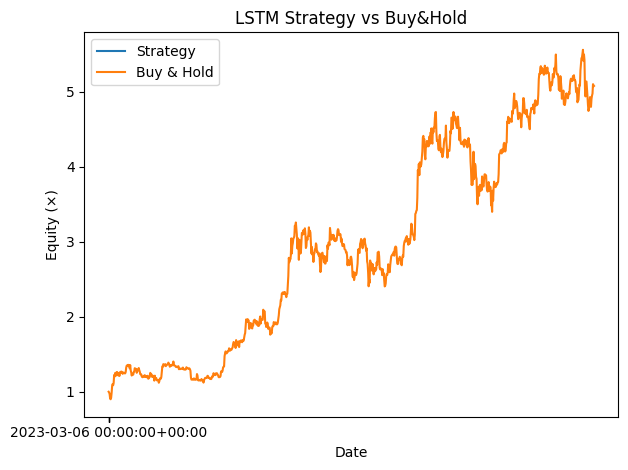

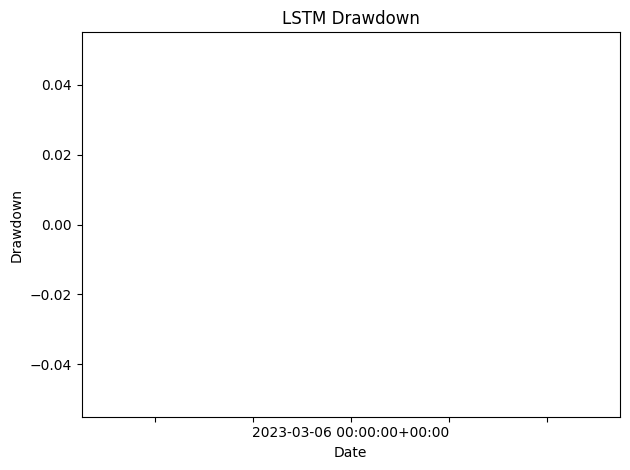

In [44]:

# -------- 7) Plots --------
import matplotlib.pyplot as plt
plot_equity(df_bt, equity_col="equity_net", equity_bh_col="equity_bh", title=f"{MODEL_KIND.upper()} Strategy vs Buy&Hold")
plt.savefig(FIGS / f"{MODEL_KIND}_equity.png", dpi=150)

plot_drawdown(df_bt, drawdown_col="drawdown", title=f"{MODEL_KIND.upper()} Drawdown")
plt.savefig(FIGS / f"{MODEL_KIND}_drawdown.png", dpi=150)

print(f"=> Saved figures to {FIGS}")

In [45]:
print("Signal summary:")
print(signal.value_counts())

print("\nFirst 10 predictions vs theta:")
check = pd.DataFrame({
    "p_up": p_up_test.head(10).values,
    "signal": signal.head(10).values
})
print(check)

print("\nEquity tail:")
print(df_bt[["equity_net", "equity_bh"]].tail())


Signal summary:
signal
1    968
Name: count, dtype: int64

First 10 predictions vs theta:
       p_up  signal
0  0.515436       1
1  0.512688       1
2  0.513441       1
3  0.517498       1
4  0.523773       1
5  0.523935       1
6  0.518887       1
7  0.510595       1
8  0.505086       1
9  0.506388       1

Equity tail:
     equity_net  equity_bh
963         NaN        NaN
964         NaN        NaN
965         NaN        NaN
966         NaN        NaN
967         NaN        NaN
